In [42]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'ai5-c1-group1'
!gcloud config set project {project_id}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



In [2]:
!pip install faiss-cpu

     |████████████████████████████████| 8.4 MB 2.6 MB/s 


In [3]:
import os
import time
import imutils
import math
import faiss
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from IPython.display import clear_output

from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from IPython.display import clear_output
from google.colab import files
from imutils import paths
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D

In [4]:
!wget https://storage.googleapis.com/artifacts.ai5-c1-group1.appspot.com/data/vision_model.zip
!unzip vision_model.zip

--2021-10-26 07:35:30--  https://storage.googleapis.com/artifacts.ai5-c1-group1.appspot.com/data/vision_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.125.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15577145 (15M) [application/zip]
Saving to: ‘vision_model.zip’

vision_model.zip    100%[===================>]  14.86M  15.1MB/s    in 1.0s    

2021-10-26 07:35:31 (15.1 MB/s) - ‘vision_model.zip’ saved [15577145/15577145]

Archive:  vision_model.zip
   creating: vision_model/
   creating: vision_model/assets/
  inflating: vision_model/saved_model.pb  
   creating: vision_model/variables/
  inflating: vision_model/variables/variables.data-00000-of-00001  
  inflating: vision_model/variables/variables.index  
  inflating: vision_model/keras_metadata.pb  


In [5]:
!wget https://storage.googleapis.com/artifacts.ai5-c1-group1.appspot.com/data/dogs.zip

--2021-10-26 07:35:40--  https://storage.googleapis.com/artifacts.ai5-c1-group1.appspot.com/data/dogs.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25122077539 (23G) [application/zip]
Saving to: ‘dogs.zip’

dogs.zip            100%[===================>]  23.40G  57.5MB/s    in 7m 49s  

2021-10-26 07:43:30 (51.1 MB/s) - ‘dogs.zip’ saved [25122077539/25122077539]



In [6]:
# !gsutil cp -r gs://artifacts.ai5-c1-group1.appspot.com/data/dogs.zip ./
!unzip dogs.zip
!rm dogs.zip
clear_output()

In [7]:
model = tf.keras.models.load_model('./vision_model')
clear_output()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
Total params: 4,049,571
Trainable params: 4,007,548
Non-trainable params: 42,023
_________________________________________________________________


In [8]:
class FeatureExtractor:
    def __init__(self, model):
        self.model = model

    def extract_features(self, image):
        # prepare image to pass through the model
        image = self.prepare_image(image)
        # get the features
        features = self.model(image)
        # convert to numpy and reshape
        features = features.numpy().reshape((-1,)) # reshape to (2048,)
        return features
        
    def prepare_image(self, image):
        # preprocess using model's preprocess_input func
        image = preprocess_input(image)
        # expand the dimension: (224, 224, 3) => (1, 224, 224, 3)
        image = np.expand_dims(image, axis=0)
        return image

In [16]:
animal_id = os.listdir('./dogs')
aids = []
paths = []
for aid in animal_id:
  img = os.listdir('./dogs/'+str(aid))
  if (len(img) < 1):
    continue
  img = img[0]
  paths.append('dogs/'+str(aid)+'/'+img)
  aids.append(aid)
print(len(paths))
print(paths[:5])
print(aids[:5])

14960
['dogs/3604400/20180412184827.png', 'dogs/14169485/20190714075008.png', 'dogs/1592595/20170317111401.png', 'dogs/1487672/20170206194925.png', 'dogs/28781569/20201102131809.png']
['3604400', '14169485', '1592595', '1487672', '28781569']


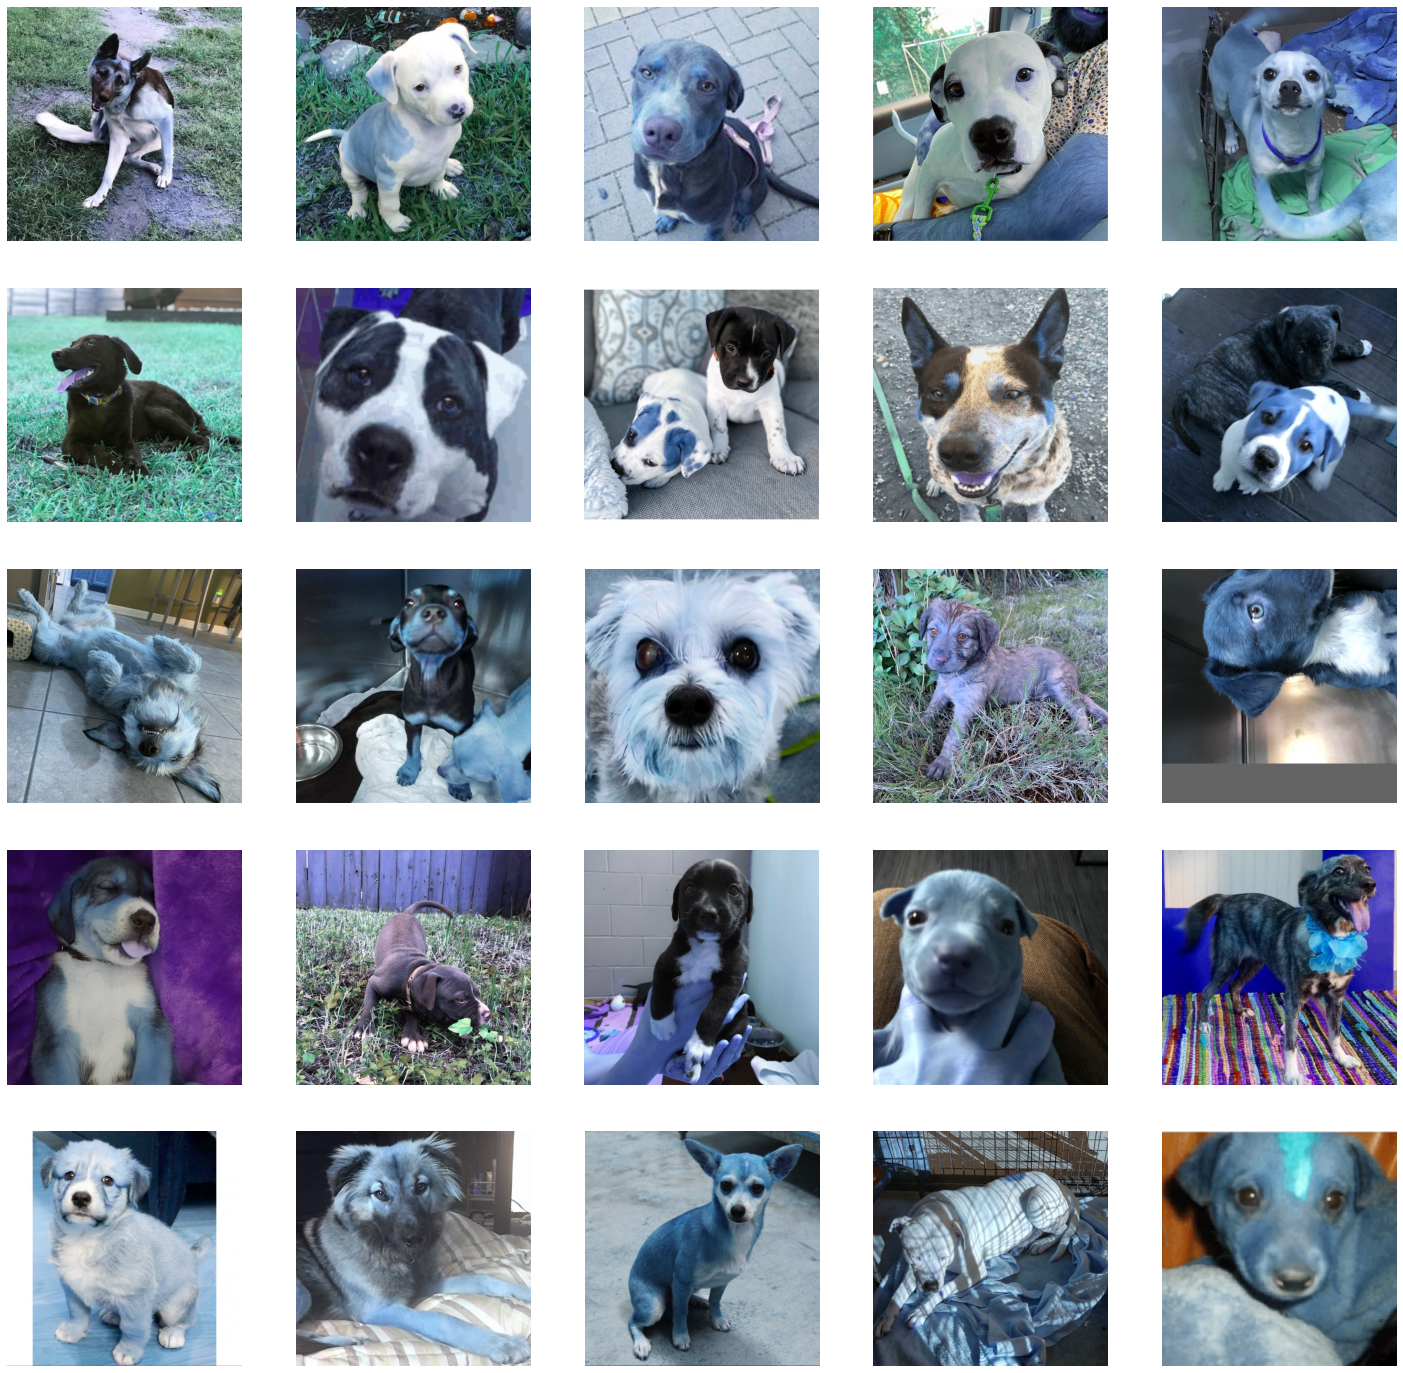

In [33]:
fig, ax = plt.subplots(5, 5, figsize=(25, 25))
ax = ax.ravel()
for i , x in enumerate(ax):
  x.imshow(cv2.imread(np.random.choice(paths)))
  x.axis('off')

In [38]:
parent_link = 'https://storage.googleapis.com/artifacts.ai5-c1-group1.appspot.com/data/'
links_df = pd.DataFrame({"AnimalID":aids, "URL":[parent_link + p for p in paths]})
links_df.to_csv("./links_df.csv", index=False)
!gsutil cp ./links_df.csv gs://artifacts.ai5-c1-group1.appspot.com/data/deployment_df/
links_df.head()

AnimalID                                                URL
0   3604400  https://storage.googleapis.com/artifacts.ai5-c...
1  14169485  https://storage.googleapis.com/artifacts.ai5-c...
2   1592595  https://storage.googleapis.com/artifacts.ai5-c...
3   1487672  https://storage.googleapis.com/artifacts.ai5-c...
4  28781569  https://storage.googleapis.com/artifacts.ai5-c...

In [81]:
def get_features(image_path):
    """ Load and preprocess image."""
    query = cv2.imread(image_path)
    query = cv2.resize(query, (224, 224), interpolation=cv2.INTER_AREA)
    query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)
    features = fe.extract_features(query)
    return features, query

def load_image(imgpath):
    image = cv2.imread(imgpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = imutils.resize(image, width=200)
    return image


# fe = FeatureExtractor(model)
# embedding_dict = {}
# for i, tup in enumerate(zip(aids, paths)):
#   aid, p = tup
#   if ((i+1)%10==0):
#     clear_output()
#     print(i+1 , '//', len(aids))
#   features = get_features(p)[0]
#   embedding_dict[aid]=features

# embedding_dict.items()[0]

In [69]:
# open the output index file for writing
output = open("features_subset", "w")

added_ids = set()
start = time.time()
for i, image_path in enumerate(paths):
    # extract the image ID
    # and load the image
    imageID = aids[i]
    if imageID not in added_ids:
        # read the image
        image = cv2.imread(image_path)

        # if image is not none: convert to RGB, resize and extract features
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
            # describe the image
            features = fe.extract_features(image)

            # write the features to file
            features = [str(f) for f in features]
            output.write("%s,%s\n" % (imageID, ",".join(features)))
            added_ids.add(imageID)
    if ((i+1) % 10 == 0):
      clear_output()
      print(i+1, ' // ', len(paths))

# close the index file
output.close()
print("Time taken {:.2f} mins".format((time.time() - start)/60))

14960  //  14960
Time taken 52.80 mins


In [70]:
df = pd.read_csv("features_subset", header=None)
df.head()

0         1         2     ...      1278      1279      1280
0   3604400  0.233830 -0.084792  ... -0.101181 -0.139686  0.077460
1  14169485  0.435008 -0.073754  ...  0.243184 -0.133294  0.056944
2   1592595  0.123436 -0.072120  ... -0.031474  0.073103  0.135964
3   1487672  0.799907 -0.117036  ... -0.090454 -0.124136 -0.143037
4  28781569 -0.105597  0.134192  ... -0.100348 -0.106685  0.302974

[5 rows x 1281 columns]

In [71]:
!gsutil cp ./features_subset gs://artifacts.ai5-c1-group1.appspot.com/data/deployment_df/

Copying file://./features_subset [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/211.3 MiB.                                    


In [72]:
# exclude AnimalInter-ID (first column)
features = df.iloc[:, 1:]
embeddings = features.values
# get embeddings shape
dim = embeddings.shape[1]
print("Dimension:", dim)

# convert to float32
embeddings = embeddings.astype(np.float32)

# initialize IndexFlatL2 index with our vector dimensionality
index = faiss.IndexFlatL2(dim)
# check whether an index needs to be trained using the is_trained method
print("is_trained?", index.is_trained)
# This will handle => ValueError: array is not C-contiguous
embeddings_fixed = embeddings.copy(order='C')

# load embeddings
index.add(embeddings_fixed)
print("total indices:",index.ntotal)

Dimension: 1280
is_trained? True
total indices: 14955


In [73]:
faiss.write_index(index, 'faiss_index')

In [94]:
def show_similar_images(query_image_path, k):
    # load image
    xq, query_image = get_features(query_image_path)
    # get query image id
    # queryID = query_image_path.split(os.path.sep)[1]
    # start tracking time
    start = time.time()
    D, I = index.search(np.array([xq]), k)
    # print(D)
    # print(I)
    print("Time taken to search: {:.2f}s".format(time.time() - start))
    # similar dogs ids
    similar_dog_ids = df[0].iloc[I[0]].values
    print(similar_dog_ids)

    # display query image
    plt.imshow(query_image)
    plt.axis("off")
    plt.title(f"Query Image", fontsize=18)
    plt.show()
    # create a figure object
    fig = plt.figure(figsize=(10, 6))
    # loop over the results and display the similar images
    for i, id in enumerate(similar_dog_ids):
        ax = fig.add_subplot(2, 5, i+1)
        p = './dogs/'+str(id)
        img_paths = os.listdir(p)
        # print(img_paths)
        image = load_image(os.path.join(p,img_paths[0]))
        plt.imshow(image)
        plt.axis('off')
        plt.title(str(id))
    plt.tight_layout()
    plt.suptitle("Similar Dogs\n", fontsize=16)
    plt.show()

Time taken to search: 0.03s
[ 8844415 27486715  8100416 25617613 17058427  2809857 14562437 11779706
 29268011 16865770]


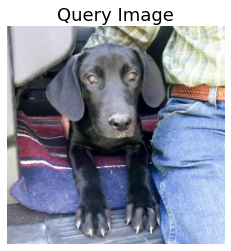

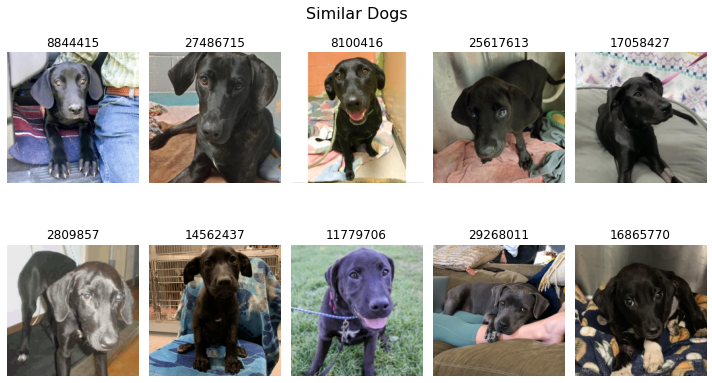

In [95]:
show_similar_images(np.random.choice(paths), 10)

Saving test.jpg to test.jpg
Time taken to search: 0.04s
[ 8102630 12657849  8083781 21352985 12698558]


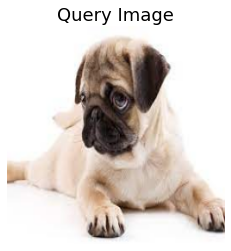

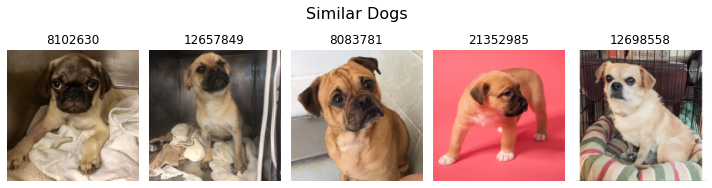

In [96]:
from google.colab import files
uploaded = files.upload()
show_similar_images(list(uploaded.keys())[0], k=5)

In [92]:
!gsutil cp ./faiss_index gs://artifacts.ai5-c1-group1.appspot.com/data/deployment_df/

Copying file://./faiss_index [Content-Type=application/octet-stream]...
|
Operation completed over 1 objects/73.0 MiB.                                     


In [93]:
index = faiss.read_index('./faiss_index')